In [1]:
from mave_calibration.initializations import gmm_init
from mave_calibration.skew_normal import density_utils,fit
import scipy.stats as sps
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from mave_calibration import em_opt
from mave_calibration.em_opt import utils
from tqdm.autonotebook import trange

/tmp/ipykernel_302794/421292023.py:9: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import trange


In [2]:
def plot(X, S, current_weights, current_params):
    N_samples = S.shape[1]
    N_components = len(current_params)
    cmap = sns.color_palette("tab10", S.shape[1] + 1)
    rng = np.arange(X.min(), X.max(), .01)
    fig,ax = plt.subplots(N_samples,1,figsize=(10,10),sharex=True,sharey=True)
    for sample_num in range(N_samples):
        sns.histplot(X[S[:,sample_num]], ax=ax[sample_num] ,stat='density')
    layer_distributions(X, S, current_weights, current_params, ax, label='estimated')
    return fig,ax

def layer_distributions(X, S, weights_, params_, ax,label="",linestyle='-'):
    cmap = sns.color_palette("tab10", S.shape[1] + 1)
    N_samples = S.shape[1]
    rng = np.arange(X.min(), X.max(), .01)
    for sample_num in range(N_samples):
        component_joint_pdfs = density_utils.joint_densities(rng, params_, weights_[sample_num])
        for component_num in range(N_components):
            ax[sample_num].plot(rng, component_joint_pdfs[component_num],
                label=f"Component {component_num} {label}",
                color=cmap[component_num],
                linestyle=linestyle)
            mixture_pdf = component_joint_pdfs.sum(axis=0)
        ax[sample_num].plot(rng, mixture_pdf, label=f"Mixture {label}",color=cmap[-1],linestyle=linestyle)

define distributions

In [3]:
true_params = [
    [1.5, -2.5, 1.5],
    [-1, 3., 2]
]

prior_prob_pathogenicity = .25
true_weights = np.array([[.85, 0.15],
                         [0.3, .7]])
population_weights = prior_prob_pathogenicity * true_weights[0] + (1 - prior_prob_pathogenicity) * true_weights[1]
true_weights = np.concatenate([true_weights,population_weights.reshape(1,2)])
n_observations = [1000,1000,5000]

sample data

In [4]:
X = np.zeros((0,))
S = np.zeros((0, len(n_observations))).astype(bool)
for sample_num, (sample_size, sample_weights) in enumerate(zip(n_observations,true_weights)):
    x = np.concatenate([sps.skewnorm.rvs(a, loc, scale, size=int(round(sample_size * w))) for (a, loc, scale),w in zip(true_params, sample_weights)])
    s = np.zeros((len(x), len(n_observations))).astype(bool)
    s[:, sample_num] = 1
    X = np.concatenate([X, x])
    S = np.concatenate([S, s])

initialize model

In [12]:
N_samples = S.shape[1]
N_components = 2
initial_params = gmm_init(X[S[:,2]],n_inits=10)

W = np.ones((N_samples, N_components)) / N_components
W = em_opt.utils.get_sample_weights(X, S, initial_params, W)
likelihoods = [em_opt.utils.get_likelihood(X, S, initial_params, W)/len(S),]
updated_component_params, updated_weights = em_opt.utils.em_iteration(X, S, initial_params, W)
likelihoods.append(em_opt.utils.get_likelihood(X, S, updated_component_params, updated_weights)/len(S))
for i in trange(1000):
    updated_component_params, updated_weights = em_opt.utils.em_iteration(X, S, updated_component_params, updated_weights)
    likelihoods.append(em_opt.utils.get_likelihood(X, S, updated_component_params, updated_weights)/len(S))
    if np.abs(likelihoods[-1] - likelihoods[-2]) < 1e-6:
        break

  7%|▋         | 66/1000 [00:01<00:16, 55.62it/s]


Text(0, 0.5, 'Negative Log Likelihood')

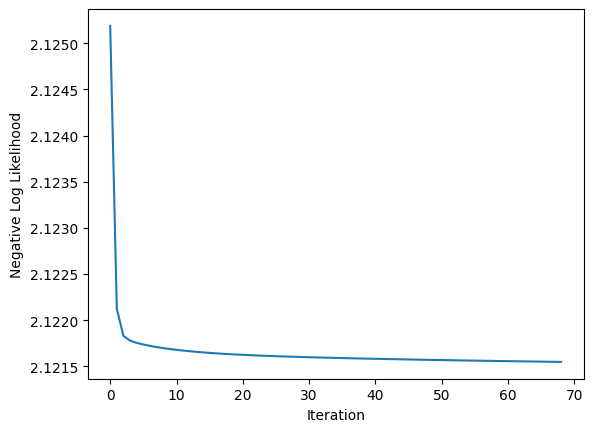

In [13]:
plt.plot(np.array(likelihoods) * -1)
plt.xlabel('Iteration')
plt.ylabel('Negative Log Likelihood')

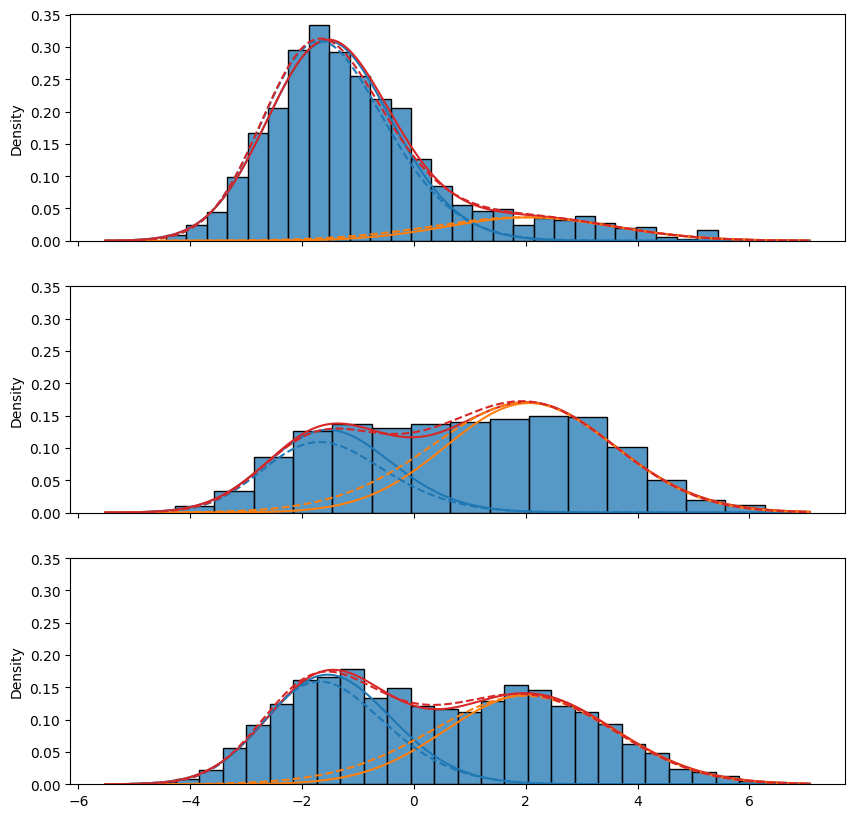

In [14]:
fig, ax = plot(X,S,updated_weights,updated_component_params)
layer_distributions(X,S,true_weights, true_params, ax, label='true',linestyle='--')